### Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import random
import warnings
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from tensorflow import optimizers

In [48]:
#remove warnings
warnings.filterwarnings("ignore")

In [2]:
#Get the data from folders
img_folder = "images/"
data = pd.read_csv('./train.csv')
TOTAL_IMAGES = len(data)

In [3]:
def plant_img_details(path):
    """Get the resolutions of each image
       @path - path to the folder of images"""
    w = []; h = []
    i = 0
    files = [os.path.join(path, file) for file in os.listdir(path)]
    for file in files:
        img = load_img(file)
        w.append(img.width)
        h.append(img.height)
    return w,h
width, height = plant_img_details(img_folder)

Height:  1369 Width:  2044


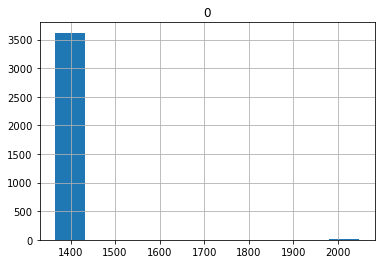

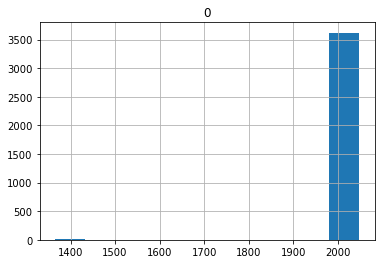

In [4]:
#display the distribution of the weights and heights
pd.DataFrame(height).hist()
pd.DataFrame(width).hist()
print("Height: ",round(np.mean(height)), "Width: ", round(np.mean(width)))

Overall, all of the images have the same resolution of 2044 x 1368 pixels or the inverse of it. Since the images don't vary in width or height, this means that when we reduce the resolution of the images to smaller pixels to train our Neural Network, we won't need to worry about whether one image is more collapse or squish than the other.

We might want to take a look at the possible combination of dimesions to find out which possible resolution is right for the images so that it's not to big for training and not too small that it's grainy and lose information during training

### View Possible Resolution Combination

In [133]:
# Possible combination: 64x64, 150x150, 196x196 ,224x224, 256x256, 384x384

#Want 2 images per resolution
NUM_IMAGES_COMB = 12
images = random.choices(os.listdir(img_folder), k = NUM_IMAGES_COMB)
images = [os.path.join(img_folder, file) for file in images]


def viewImg(files, size, labels = [], save = False):
        
    fig = plt.figure(figsize= (10, 10))
    for i, file in enumerate(files):
        img = load_img(file, target_size = (size, size))
        ax = fig.add_subplot(2,2, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if (len(labels) == len(files)):
            ax.set_title(labels[i].title(), fontdict={'fontsize': 14, 'fontweight': 'medium'})

        plt.imshow(img, interpolation = 'None', aspect= 'auto')
    if (save):
        fig.savefig("class_labels.png")
    fig.suptitle('Image Resolution at '+ str(size) + ' x ' + str(size)) 
    plt.show()
    

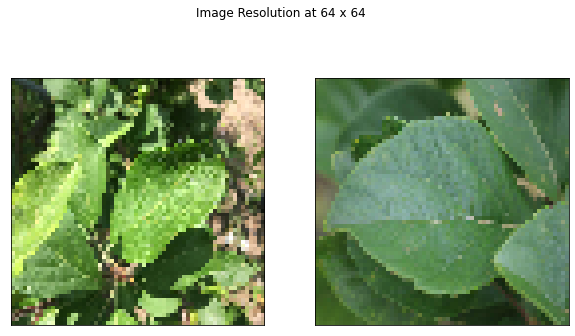

In [59]:
viewImg(images[:2], 64)

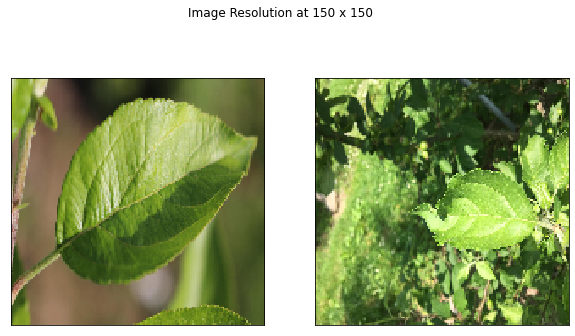

In [60]:
viewImg(images[2:4], 150)

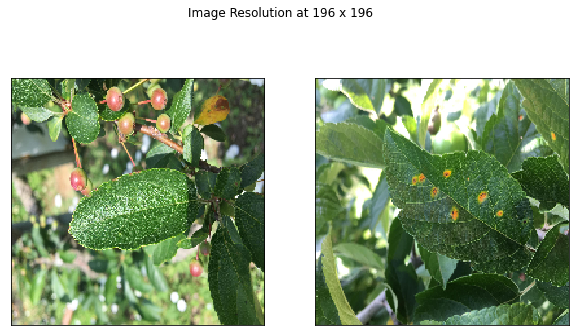

In [61]:
viewImg(images[4:6], 196)

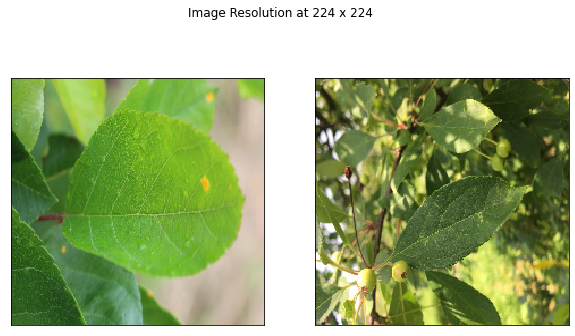

In [62]:
viewImg(images[6:8], 224)

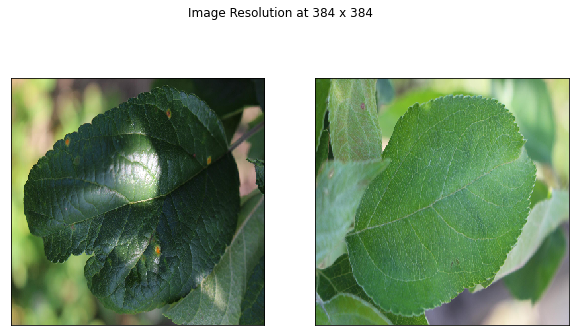

In [73]:
viewImg(images[10:12], 384)

The different resolution from the images above, particularly when they're below 150 pixels, we can visibly see the graininess from the images without zooming in. While the other resolution seems adequate. During training, I will test on the pixels size > 150 and report the optimal resolution that produce the most promising accuracy.

**Note:** The higher the resolution, the better the model will be but at the cost of training time.

### Display class images

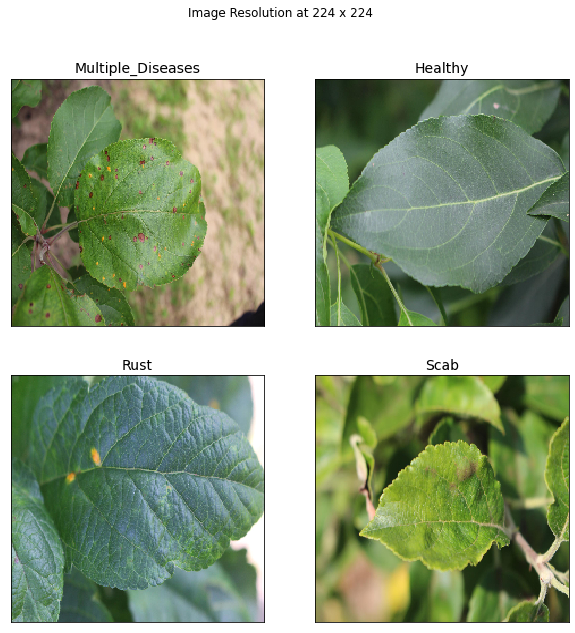

In [134]:
def generate_random_label_images():
    files = []
    labels = []
    for i, file_dir in enumerate(os.listdir(train_dir)):
        _dir = os.path.join(train_dir, file_dir)
        files.append(os.path.join(_dir, random.choice(os.listdir(_dir))))
        labels.append(file_dir)
    return files, labels
rand_imgs, rand_img_labels = generate_random_label_images()

viewImg(rand_imgs, 224, rand_img_labels, True)

### Setting Up

In [6]:
train_set, valid_set = train_test_split(data, test_size = 0.2, random_state = 3)
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)
IMG_SIZE = 224
NUM_EPOCHS = 30
BATCH_SIZE = 32
TRAIN_SIZE = len(train_set)
VALID_SIZE = len(valid_set)
TRAIN_STEP_PER_EPOCH = TRAIN_SIZE//BATCH_SIZE
VALID_STEP_PER_EPOCH = VALID_SIZE//BATCH_SIZE

In [7]:
features = ['healthy', 'multiple_diseases', 'rust', 'scab']

# make_dirs: Make the directory for the features
#@ path - relative path to store the features
def make_dirs(path):
    """
        Make the directory for the features
        @path - the relative path to store the features

    """
    if (not os.path.exists(path)):
        os.makedirs(path)
        [os.makedirs(os.path.join(path, feature)) for feature in features]
        
make_dirs('./train_features')
make_dirs('./valid_features')

#store the directory path
train_dir = './train_features'
valid_dir = './valid_features'

In [8]:
from shutil import copy
def append_files(dir_location, data):
    """
    Add the images to the corresponding feature folders
    @folder_name 
    @data - the dataframe that contains the set of features
    """
    for i in range(len(data)):
        index = np.argmax(data.iloc[i, 1:])
        data.image_id[i]
        img = os.path.join(img_folder, data.image_id[i]+'.jpg')
        feature_dir = os.path.join(dir_location, features[index])
        copy(img, feature_dir)

append_files('train_features', train_set)
append_files('valid_features', valid_set)

In [9]:
def print_num_features(dir_folder):
    """Display the number of features in folder
       @dir_folder - directory of the folder within a subfolders"""
    print(dir_folder.title()[2:] + ':')
    for feature in os.listdir(dir_folder):
        print(feature, len(os.listdir(os.path.join(dir_folder, feature))))
        
print_num_features(train_dir)
print_num_features(valid_dir)

Train_Features:
multiple_diseases 77
healthy 405
rust 511
scab 463
Valid_Features:
multiple_diseases 14
healthy 111
rust 111
scab 129


Note: There are fewer samples for plants with multiple diseases. This could negatively impact our model accuracy because it has fewer training points and therefore the model might misclassify.

### Image Generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator (
        rescale= 1./255,
        rotation_range = 90,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        brightness_range = [0.3, 1],
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Update our train image generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(IMG_SIZE, IMG_SIZE),  
        #Since our data is relatively small, we will start with 32 for our batch size
        batch_size= BATCH_SIZE,
        #Since we are working with multi-class classification, we want to use categorical
        class_mode='categorical')
    
val_datagen = ImageDataGenerator(rescale=1./255)

    
validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical')

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


### Display the different variations of image augmentation

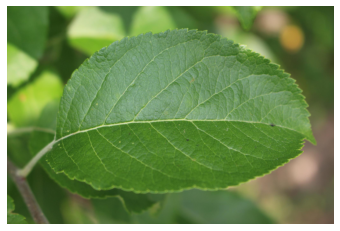

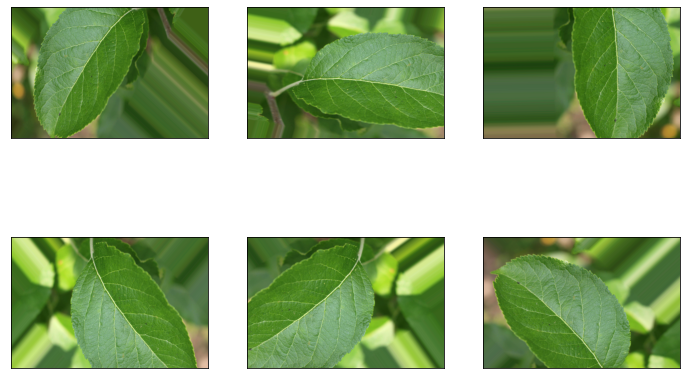

In [137]:
#Let's first take a look at an image and see how data generator augment the images
example_img = os.path.join(img_folder, random.choice(os.listdir(img_folder)))
example_img = load_img(example_img)
plt.axis('off')
plt.imshow(example_img)
arr = img_to_array(example_img)
arr = arr.reshape((1,) + arr.shape) 

example_gen = ImageDataGenerator (
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    brightness_range = [0.2, 0.5],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

i = 0

fig = plt.figure(figsize= (12,12))

for batch in example_gen.flow(arr, batch_size = 1):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(array_to_img(batch[0]))
    i+=1
    if (i > 5):
        break;
plt.show()

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 5, restore_best_weights = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= "optimal_weights.h5",
    save_best_only=True)

history = CNN.fit(
      train_generator,
      steps_per_epoch=  TRAIN_STEP_PER_EPOCH,
      epochs = NUM_EPOCHS,
      validation_data= validation_generator,
      validation_steps= VALID_STEP_PER_EPOCH, 
      callbacks = [early_stop, model_checkpoint],
      verbose=2)

2021-12-03 21:46:06.617618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
45/45 - 97s - loss: 1.3006 - accuracy: 0.3532 - val_loss: 1.2018 - val_accuracy: 0.3438
Epoch 2/30
45/45 - 99s - loss: 1.2365 - accuracy: 0.3750 - val_loss: 1.1986 - val_accuracy: 0.4375
Epoch 3/30
45/45 - 91s - loss: 1.2259 - accuracy: 0.3954 - val_loss: 1.1697 - val_accuracy: 0.4773
Epoch 4/30
45/45 - 89s - loss: 1.1837 - accuracy: 0.4621 - val_loss: 1.0654 - val_accuracy: 0.5284
Epoch 5/30
45/45 - 87s - loss: 1.1428 - accuracy: 0.5126 - val_loss: 1.0624 - val_accuracy: 0.5795
Epoch 6/30
45/45 - 89s - loss: 1.0591 - accuracy: 0.5611 - val_loss: 1.0058 - val_accuracy: 0.5824
Epoch 7/30
45/45 - 92s - loss: 1.0100 - accuracy: 0.6018 - val_loss: 0.8855 - val_accuracy: 0.6562
Epoch 8/30
45/45 - 95s - loss: 0.9586 - accuracy: 0.6215 - val_loss: 0.9022 - val_accuracy: 0.6818
Epoch 9/30
45/45 - 96s - loss: 0.9230 - accuracy: 0.6500 - val_loss: 0.7644 - val_accuracy: 0.7017
Epoch 10/30
45/45 - 95s - loss: 0.8718 - accuracy: 0.6756 - val_loss: 0.8210 - val_accuracy: 0.6903
Epoch 11/

### Analyze Model Performance

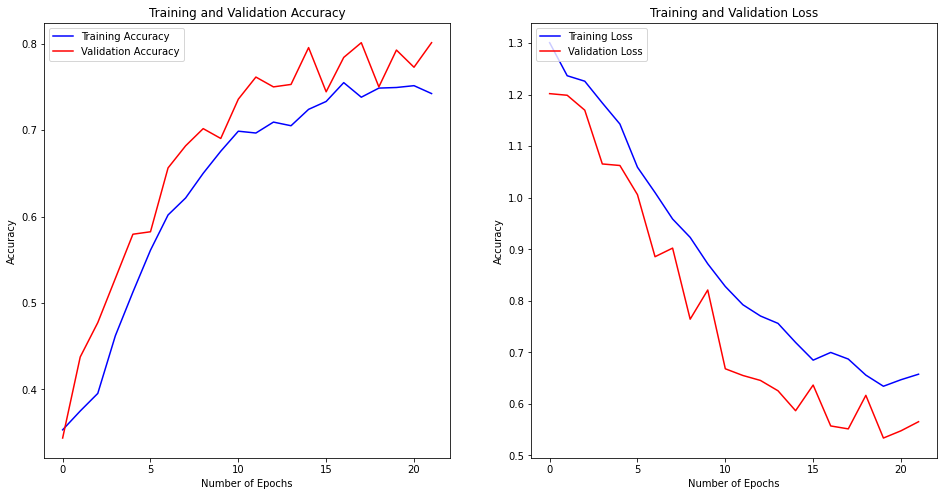

In [14]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

_, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(16,8))

def performance_graph (ax, num_epochs, train_acc, valid_acc, position, _type):
    ax.plot(num_epochs, train_acc, '-b',label = 'Training ' + _type)
    ax.plot(num_epochs, valid_acc, '-r', label = 'Validation ' + _type)
    ax.legend(loc= position)
    ax.set_title('Training and Validation '+ _type)
    ax.set_xlabel('Number of Epochs')
    ax.set_ylabel('Accuracy')
    
# Get number of epochs
epochs = range(len(acc))
performance_graph(ax1, NUM_EPOCHS, acc, val_acc, position = 'upper left', _type= 'Accuracy')
performance_graph(ax2, NUM_EPOCHS, loss, val_loss, position= 'upper left', _type= 'Loss')

In [56]:
from sklearn.metrics import classification_report

#validation generator:
    #Data on which to evaluate the loss and any model metrics at the end of each epoch. 
    #The model will not be trained on this data. 

validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical', 
    shuffle= False) 
    #shuffle has to be false or else when we predict,
    #it will randomize the class label making prediction really low

y_pred = CNN.predict(validation_generator , VALID_STEP_PER_EPOCH)
y_pred = np.argmax(y_pred, axis=1)

Found 365 images belonging to 4 classes.


In [57]:
print(classification_report(validation_generator.classes, y_pred, target_names=features))

                   precision    recall  f1-score   support

          healthy       0.74      0.61      0.67       111
multiple_diseases       0.00      0.00      0.00        14
             rust       0.88      0.96      0.92       111
             scab       0.71      0.84      0.77       129

         accuracy                           0.78       365
        macro avg       0.58      0.60      0.59       365
     weighted avg       0.74      0.78      0.76       365



In [139]:
def displayLayers(model, file = None):
        """
            Randomly pick an image and process it through the CNN and display the result
            source: https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks
                    //I just edit some stuff about the display
        """
        
        if (file is None):
            #select a random image from the directory
            img_file = random.choice(os.listdir(img_folder))
            #get relative path of img
            file = os.path.join(img_folder,  img_file)
            print("Selected Image: ", img_file)

        #load the image and rescale
        img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
        #Show original image
        plt.imshow(img)
        plt.savefig('test.png')
        x = img_to_array(img)

        # Numpy array with shape (1, 150, 150, 3)
        x = x.reshape((1,) + x.shape)  

        # Rescale to img to [0,1]
        x /= 255
        layer_names = [layer.name for layer in model.layers[1:]]
        layer_outputs = [layer.output for layer in model.layers[1:]]
        display_model = Model(model.input, layer_outputs)

        #predict the input
        feature_maps = display_model.predict(x) 

        images_per_row = 6
        max_images = 6

        #display each convoluted filter
        for layer_name, feature_map in zip(layer_names, feature_maps):
            if len(feature_map.shape) == 4:
            # Just do this for the conv / maxpool layers, not the fully-connected layers
                # number of features in feature map
                
                n_features = feature_map.shape[-1]
                n_features = min(n_features, max_images)

                # The feature map has shape (1, size, size, n_features)
                size = feature_map.shape[1]

                # We will tile our images in this matrix
                n_cols = n_features // images_per_row
                display_grid = np.zeros((size * n_cols, size * images_per_row))

                for col in range(n_cols):
                    for row in range(images_per_row):
                        x = feature_map[0, 
                                        :, :,
                                        col * images_per_row + row]
                        #standardize image for us to see image
                        x -= x.mean()
                        x /= x.std()
                        x *= 64
                        x += 128
                        x = np.clip(x, 0, 255).astype('uint8')
                          # We'll tile each filter into this big horizontal grid
                        display_grid[col * size : (col + 1) * size,
                                     row * size : (row + 1) * size] = x

                # Display the grid
                scale = 2. / size
                plt.figure(figsize=(scale * display_grid.shape[1], 
                                    scale * display_grid.shape[0]))
                plt.title(layer_name)
                plt.grid(False)    
                plt.axis('off')
                plt.imshow(display_grid, aspect='auto', cmap = 'viridis')  

Selected Image:  Train_965.jpg


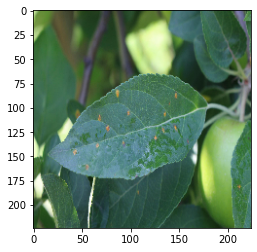

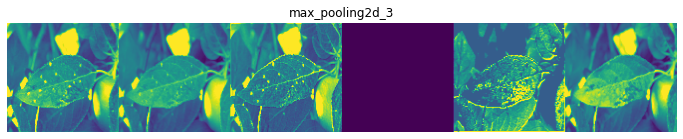

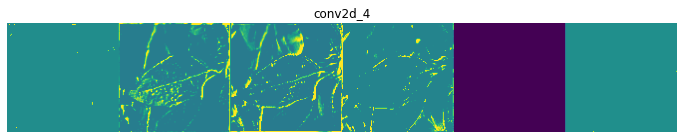

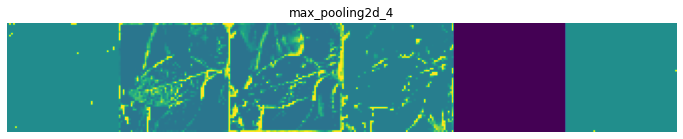

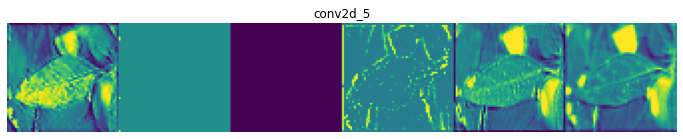

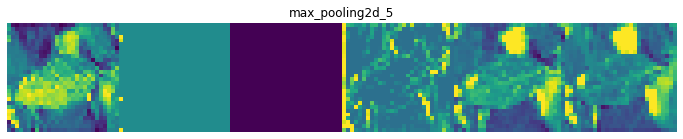

In [143]:
displayLayers(CNN)

### Make Predictions

In [158]:
#Get the optimal weights from the model
model = tf.keras.models.load_model("optimal_weights.h5")
model.evaluate(validation_generator)

12/12 [==============================] - 30s 2s/step - loss: 0.5368 - accuracy: 0.7918


[0.5367550849914551, 0.7917808294296265]

### Store best model for the web app

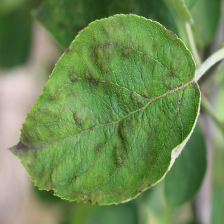

In [224]:
file = os.path.join(img_folder, random.choice(os.listdir(img_folder)))
#load image at specified size
img = load_img(file, target_size= (224,224))
img

In [225]:
#convert image to array of pixels to feed into model
img_arr = img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255
y_pred = model.predict(img_arr)
index = np.argmax(y_pred)
acc = np.ndarray.flatten(y_pred)[index]

label = features[index]
print("The model predicts that the image is {:.2f}% {}".format(acc * 100, label))

The model predicts that the image is 72.56% scab


In [145]:
from keras_preprocessing import image
test_set = pd.read_csv("./test.csv")
test_set

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [146]:
def getTestSet(df):
    x_test = []
    for image in test_set.image_id:
        file = os.path.join(img_folder, image + ".jpg")
        img = load_img(file, target_size = (IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x_test.append(x)
    return x_test

X_test = getTestSet(test_set)
# rescale images
X_test = np.vstack(X_test) / 255 

In [147]:
y_pred = model.predict(X_test, batch_size = BATCH_SIZE)
pd.DataFrame(y_pred).apply(np.argmax, axis=1)

### Extending our model using pre-trained Models

In [155]:
import inspect
from tqdm import tqdm
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB2': <function keras.appl

In [156]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

#Use different pre-trained models to see which one has the highest accuracy
for model_name, model in tqdm(model_dictionary.items()):
    #"NASNetLarge" requires different images size (331,331) but we only want 224
    if 'NASNetLarge' in model_name:
        continue
    else:
        input_shape=(224,224,3)
        
    # load the pre-trained model and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='max', input_shape=input_shape)
    pre_trained_model.trainable = False
    
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(4, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])    

  
    history = clf_model.fit(
      train_generator,
      steps_per_epoch= TRAIN_STEP_PER_EPOCH ,
      epochs=2,
      validation_data=validation_generator,
      validation_steps= VALID_STEP_PER_EPOCH,
      verbose=2)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    print(model_name)


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Epoch 1/2
45/45 - 171s - loss: 1.8331 - accuracy: 0.4143 - val_loss: 1.3404 - val_accuracy: 0.5170
Epoch 2/2
45/45 - 164s - loss: 1.3933 - accuracy: 0.5281 - val_loss: 1.0896 - val_accuracy: 0.5994


  4%|█▍                                       | 1/28 [05:40<2:33:02, 340.11s/it]

DenseNet121
Epoch 1/2
45/45 - 198s - loss: 1.9803 - accuracy: 0.3834 - val_loss: 1.1019 - val_accuracy: 0.5795
Epoch 2/2
45/45 - 191s - loss: 1.3877 - accuracy: 0.5112 - val_loss: 0.8811 - val_accuracy: 0.6506


  7%|██▉                                      | 2/28 [12:14<2:41:14, 372.09s/it]

DenseNet169
Epoch 1/2
45/45 - 256s - loss: 1.7120 - accuracy: 0.4199 - val_loss: 1.1229 - val_accuracy: 0.5653
Epoch 2/2
45/45 - 250s - loss: 1.2881 - accuracy: 0.5463 - val_loss: 0.8123 - val_accuracy: 0.7131


 11%|████▍                                    | 3/28 [20:46<3:01:38, 435.95s/it]

DenseNet201
Epoch 1/2
45/45 - 104s - loss: 4.2209 - accuracy: 0.3188 - val_loss: 2.6706 - val_accuracy: 0.3295
Epoch 2/2
45/45 - 101s - loss: 3.5034 - accuracy: 0.3041 - val_loss: 2.1755 - val_accuracy: 0.3295


 14%|█████▊                                   | 4/28 [24:15<2:18:35, 346.49s/it]

EfficientNetB0
Epoch 1/2
45/45 - 118s - loss: 4.9747 - accuracy: 0.2935 - val_loss: 4.6999 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 111s - loss: 4.1632 - accuracy: 0.3153 - val_loss: 2.3253 - val_accuracy: 0.3295


 18%|███████▎                                 | 5/28 [28:08<1:57:02, 305.33s/it]

EfficientNetB1
Epoch 1/2
45/45 - 123s - loss: 8.4591 - accuracy: 0.2985 - val_loss: 9.4018 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 112s - loss: 6.9618 - accuracy: 0.3041 - val_loss: 6.0283 - val_accuracy: 0.3153


 21%|████████▊                                | 6/28 [32:06<1:43:38, 282.67s/it]

EfficientNetB2
Epoch 1/2
45/45 - 139s - loss: 3.0568 - accuracy: 0.3027 - val_loss: 2.4273 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 131s - loss: 2.7137 - accuracy: 0.3041 - val_loss: 2.1817 - val_accuracy: 0.3153


 25%|██████████▎                              | 7/28 [36:41<1:37:57, 279.87s/it]

EfficientNetB3
Epoch 1/2
45/45 - 169s - loss: 6.1364 - accuracy: 0.3174 - val_loss: 4.0695 - val_accuracy: 0.3295
Epoch 2/2
45/45 - 158s - loss: 5.1575 - accuracy: 0.2879 - val_loss: 5.4285 - val_accuracy: 0.3295


 29%|███████████▋                             | 8/28 [42:14<1:38:56, 296.81s/it]

EfficientNetB4
Epoch 1/2
45/45 - 224s - loss: 13.1340 - accuracy: 0.2914 - val_loss: 2.4863 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 213s - loss: 9.2369 - accuracy: 0.3202 - val_loss: 4.5143 - val_accuracy: 0.3295


 32%|█████████████▏                           | 9/28 [49:37<1:48:28, 342.53s/it]

EfficientNetB5
Epoch 1/2
45/45 - 280s - loss: 14.4722 - accuracy: 0.2999 - val_loss: 7.5927 - val_accuracy: 0.0398
Epoch 2/2
45/45 - 268s - loss: 11.3280 - accuracy: 0.2956 - val_loss: 9.1528 - val_accuracy: 0.3153


 36%|██████████████▎                         | 10/28 [58:52<2:02:25, 408.10s/it]

EfficientNetB6
Epoch 1/2
45/45 - 379s - loss: 11.4807 - accuracy: 0.3216 - val_loss: 9.2304 - val_accuracy: 0.3295
Epoch 2/2
45/45 - 365s - loss: 9.5079 - accuracy: 0.2935 - val_loss: 7.0209 - val_accuracy: 0.3295


 39%|██████████████▉                       | 11/28 [1:11:25<2:25:35, 513.85s/it]

EfficientNetB7
Epoch 1/2
45/45 - 219s - loss: 2.5898 - accuracy: 0.3357 - val_loss: 1.2895 - val_accuracy: 0.4886
Epoch 2/2
45/45 - 203s - loss: 1.8125 - accuracy: 0.4480 - val_loss: 2.1839 - val_accuracy: 0.4545


 43%|████████████████▎                     | 12/28 [1:18:35<2:10:14, 488.42s/it]

InceptionResNetV2
Epoch 1/2
45/45 - 127s - loss: 2.6624 - accuracy: 0.3785 - val_loss: 1.3272 - val_accuracy: 0.5341
Epoch 2/2
45/45 - 123s - loss: 2.0169 - accuracy: 0.4459 - val_loss: 2.0696 - val_accuracy: 0.4318


 46%|█████████████████▋                    | 13/28 [1:22:50<1:44:22, 417.47s/it]

InceptionV3
Epoch 1/2
45/45 - 96s - loss: 3.1876 - accuracy: 0.3926 - val_loss: 1.7287 - val_accuracy: 0.5142
Epoch 2/2
45/45 - 92s - loss: 2.1666 - accuracy: 0.4986 - val_loss: 1.8760 - val_accuracy: 0.5881


 50%|███████████████████                   | 14/28 [1:26:00<1:21:24, 348.89s/it]

MobileNet
Epoch 1/2
45/45 - 92s - loss: 2.9763 - accuracy: 0.3890 - val_loss: 1.3927 - val_accuracy: 0.5767
Epoch 2/2
45/45 - 91s - loss: 1.9242 - accuracy: 0.5218 - val_loss: 2.5065 - val_accuracy: 0.4574


 54%|████████████████████▎                 | 15/28 [1:29:05<1:04:53, 299.48s/it]

MobileNetV2
Epoch 1/2
45/45 - 93s - loss: 1.2962 - accuracy: 0.3272 - val_loss: 1.2390 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 90s - loss: 1.2724 - accuracy: 0.3216 - val_loss: 1.2716 - val_accuracy: 0.3153


 57%|██████████████████████▊                 | 16/28 [1:32:11<53:04, 265.34s/it]

MobileNetV3Large
Epoch 1/2
45/45 - 80s - loss: 1.2663 - accuracy: 0.3322 - val_loss: 1.2756 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 74s - loss: 1.2566 - accuracy: 0.3308 - val_loss: 1.2270 - val_accuracy: 0.3295


 61%|████████████████████████▎               | 17/28 [1:34:48<42:39, 232.64s/it]

MobileNetV3Small
Epoch 1/2
45/45 - 119s - loss: 2.1764 - accuracy: 0.3827 - val_loss: 1.5856 - val_accuracy: 0.4375
Epoch 2/2
45/45 - 109s - loss: 1.5732 - accuracy: 0.4867 - val_loss: 1.0050 - val_accuracy: 0.6364


 68%|███████████████████████████▏            | 19/28 [1:38:43<26:55, 179.50s/it]

NASNetMobile
Epoch 1/2
45/45 - 262s - loss: 1.4176 - accuracy: 0.3258 - val_loss: 1.7287 - val_accuracy: 0.3153
Epoch 2/2
45/45 - 260s - loss: 1.3805 - accuracy: 0.3272 - val_loss: 1.2822 - val_accuracy: 0.3466


 71%|████████████████████████████▌           | 20/28 [1:47:31<35:27, 265.96s/it]

ResNet101
Epoch 1/2
45/45 - 231s - loss: 3.9316 - accuracy: 0.4361 - val_loss: 1.7194 - val_accuracy: 0.5994
Epoch 2/2
45/45 - 229s - loss: 2.6173 - accuracy: 0.5407 - val_loss: 1.8813 - val_accuracy: 0.6364


 75%|██████████████████████████████          | 21/28 [1:55:15<37:04, 317.82s/it]

ResNet101V2
Epoch 1/2
45/45 - 380s - loss: 1.4040 - accuracy: 0.3230 - val_loss: 1.2335 - val_accuracy: 0.3551
Epoch 2/2
45/45 - 374s - loss: 1.3547 - accuracy: 0.3357 - val_loss: 1.2548 - val_accuracy: 0.3608


 79%|███████████████████████████████▍        | 22/28 [2:07:56<43:51, 438.50s/it]

ResNet152
Epoch 1/2
45/45 - 332s - loss: 3.4163 - accuracy: 0.4431 - val_loss: 2.3533 - val_accuracy: 0.5398
Epoch 2/2
45/45 - 330s - loss: 2.4626 - accuracy: 0.5358 - val_loss: 1.8547 - val_accuracy: 0.5852


 82%|████████████████████████████████▊       | 23/28 [2:19:04<41:53, 502.66s/it]

ResNet152V2
Epoch 1/2
45/45 - 171s - loss: 1.5337 - accuracy: 0.3083 - val_loss: 1.4180 - val_accuracy: 0.3125
Epoch 2/2
45/45 - 166s - loss: 1.4054 - accuracy: 0.3378 - val_loss: 1.4660 - val_accuracy: 0.4062


 86%|██████████████████████████████████▎     | 24/28 [2:24:44<30:24, 456.21s/it]

ResNet50
Epoch 1/2
45/45 - 143s - loss: 3.7679 - accuracy: 0.4298 - val_loss: 2.0298 - val_accuracy: 0.5767
Epoch 2/2
45/45 - 142s - loss: 2.3198 - accuracy: 0.5639 - val_loss: 2.3647 - val_accuracy: 0.6108


 89%|███████████████████████████████████▋    | 25/28 [2:29:32<20:22, 407.39s/it]

ResNet50V2
Epoch 1/2
45/45 - 395s - loss: 1.2943 - accuracy: 0.3666 - val_loss: 1.2272 - val_accuracy: 0.4091
Epoch 2/2
45/45 - 395s - loss: 1.2436 - accuracy: 0.3876 - val_loss: 1.1811 - val_accuracy: 0.4631


 93%|█████████████████████████████████████▏  | 26/28 [2:42:43<17:19, 519.73s/it]

VGG16
Epoch 1/2
45/45 - 485s - loss: 1.3066 - accuracy: 0.3287 - val_loss: 1.2587 - val_accuracy: 0.3324
Epoch 2/2
45/45 - 480s - loss: 1.2110 - accuracy: 0.4171 - val_loss: 1.2276 - val_accuracy: 0.3693


 96%|██████████████████████████████████████▌ | 27/28 [2:58:51<10:51, 651.96s/it]

VGG19
Epoch 1/2
45/45 - 168s - loss: 1.4489 - accuracy: 0.4333 - val_loss: 1.0618 - val_accuracy: 0.5710
Epoch 2/2
45/45 - 166s - loss: 1.1692 - accuracy: 0.5337 - val_loss: 0.9261 - val_accuracy: 0.6420


100%|████████████████████████████████████████| 28/28 [3:04:29<00:00, 395.33s/it]

Xception


In [157]:
pd.DataFrame(model_benchmarks).sort_values(by= "validation_accuracy", ascending= False)

,model_name,num_model_params,validation_accuracy
2,DenseNet201,18321984,0.713068
1,DenseNet169,12642880,0.650568
26,Xception,20861480,0.642045
19,ResNet101V2,42626560,0.636364
17,NASNetMobile,4269716,0.636364
23,ResNet50V2,23564800,0.610795
0,DenseNet121,7037504,0.599432
13,MobileNet,3228864,0.588068
21,ResNet152V2,58331648,0.585227
24,VGG16,14714688,0.463068


### Using DenseNet and Xception as pre-trained model

In [367]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet201

def extend_base_model(base_model_name = "DenseNet201"):
    
    model = DenseNet201(include_top = False, #don't want to include the fully connected layer where it predicts different classes
                                 weights = 'imagenet', #load weights pre-trained on ImageNet
                                 input_shape = (IMG_SIZE, IMG_SIZE, 3))
    
    if (base_model_name == "Xception"):
         model = Xception(include_top = False, #don't want to include the fully connected layer where it predicts different classes
                                 weights = 'imagenet', #load weights pre-trained on ImageNet
                                 input_shape = (IMG_SIZE, IMG_SIZE, 3))
    
    #Next step is to freeze all the layers so that when we add new layers to the model,
    #it won't update the already learned features from the pretrained model    
    model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #set training to false to set base model in inference mode
    x = model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #add our the last layer because we have 4 class lab
    outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)
    
    #set early stop so that our model won't overfit and take too long
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'acc', patience = 3, restore_best_weights = True)

    #set up training for the new layer     
    print("Training new layer....\n")

    base_model = tf.keras.Model(inputs, outputs)
    base_model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['acc'])

    base_model.fit(
      train_generator,
      steps_per_epoch= TRAIN_STEP_PER_EPOCH ,
      epochs = 15,
      validation_data=validation_generator,
      validation_steps= VALID_STEP_PER_EPOCH,
      verbose=2,
      callbacks = [early_stop]) #since we are only training the new layer, it won't have the optimal weight
    
    #Afterward, we fine tuning the pretrained models by now allowing the weights of other layers to get updated
    print("Fine tuning....\n")
    model.trainable = True
    
    #Store optimal weights
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = "optimal_weights_" + base_model_name + ".h5", save_best_only=True)
    
    base_model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['acc'])

    base_model.fit(
      train_generator,
      steps_per_epoch= TRAIN_STEP_PER_EPOCH ,
      epochs = 15,
      validation_data=validation_generator,
      validation_steps= VALID_STEP_PER_EPOCH,
      verbose=2,
      callbacks = [early_stop, model_checkpoint]
      )
    
    return base_model
    

In [368]:
#Each model takes about 3-5 hours to complete
pre_trained_dense201 = extend_base_model("DenseNet201")

Training new layer....

Epoch 1/15
45/45 - 389s - loss: 1.1393 - acc: 0.5000 - val_loss: 0.9195 - val_acc: 0.6761
Epoch 2/15
45/45 - 337s - loss: 0.9241 - acc: 0.6833 - val_loss: 0.7889 - val_acc: 0.7273
Epoch 3/15
45/45 - 354s - loss: 0.8455 - acc: 0.7015 - val_loss: 0.7336 - val_acc: 0.7301
Epoch 4/15
45/45 - 312s - loss: 0.7791 - acc: 0.7233 - val_loss: 0.6469 - val_acc: 0.7699
Epoch 5/15
45/45 - 314s - loss: 0.7276 - acc: 0.7535 - val_loss: 0.6708 - val_acc: 0.7614
Epoch 6/15
45/45 - 345s - loss: 0.6876 - acc: 0.7619 - val_loss: 0.6419 - val_acc: 0.7670
Epoch 7/15
45/45 - 379s - loss: 0.6793 - acc: 0.7683 - val_loss: 0.6279 - val_acc: 0.7642
Epoch 8/15
45/45 - 345s - loss: 0.6424 - acc: 0.7697 - val_loss: 0.6459 - val_acc: 0.7585
Epoch 9/15
45/45 - 337s - loss: 0.6474 - acc: 0.7654 - val_loss: 0.5577 - val_acc: 0.7955
Epoch 10/15
45/45 - 336s - loss: 0.6099 - acc: 0.7851 - val_loss: 0.5414 - val_acc: 0.8125
Epoch 11/15
45/45 - 346s - loss: 0.6037 - acc: 0.8013 - val_loss: 0.5140 - 

In [293]:
pre_trained_xception = extend_base_model("Xception") 

Training new layer....

Epoch 1/15
45/45 - 196s - loss: 1.1297 - acc: 0.5126 - val_loss: 0.9392 - val_acc: 0.6023
Epoch 2/15
45/45 - 178s - loss: 0.9468 - acc: 0.6271 - val_loss: 0.8320 - val_acc: 0.6761
Epoch 3/15
45/45 - 186s - loss: 0.8685 - acc: 0.6706 - val_loss: 0.7841 - val_acc: 0.7074
Epoch 4/15
45/45 - 176s - loss: 0.8295 - acc: 0.6987 - val_loss: 0.7728 - val_acc: 0.7017
Epoch 5/15
45/45 - 177s - loss: 0.7698 - acc: 0.7149 - val_loss: 0.7599 - val_acc: 0.7045
Epoch 6/15
45/45 - 174s - loss: 0.7646 - acc: 0.7163 - val_loss: 0.7530 - val_acc: 0.7045
Epoch 7/15
45/45 - 179s - loss: 0.7553 - acc: 0.7240 - val_loss: 0.7596 - val_acc: 0.6733
Epoch 8/15
45/45 - 177s - loss: 0.7484 - acc: 0.7212 - val_loss: 0.6986 - val_acc: 0.7273
Epoch 9/15
45/45 - 178s - loss: 0.7226 - acc: 0.7430 - val_loss: 0.7150 - val_acc: 0.7330
Epoch 10/15
45/45 - 179s - loss: 0.7119 - acc: 0.7381 - val_loss: 0.6731 - val_acc: 0.7642
Epoch 11/15
45/45 - 174s - loss: 0.6958 - acc: 0.7444 - val_loss: 0.7200 - 

### Visualizing the final result of pretrained model

In [349]:
dense201_hist = pre_trained_dense201.history.history
xception_hist = pre_trained_xception.history.history

    
assert(len(dense201_hist['val_acc']), len(xception_hist['val_acc']))
EPOCHS = range(len(dense201_hist['val_acc']))


def base_performance_graph (ax, num_epochs, train_acc, valid_acc, position, _type, model_name):
    ax.plot(num_epochs, train_acc, '-b',label = 'Training ' + _type)
    ax.plot(num_epochs, valid_acc, '-r', label = 'Validation ' + _type)
    ax.legend(loc= position)
    ax.set_title(model_name + " " +  _type + ' Performance')
    ax.set_xlabel('Number of Epochs')
    ax.set_ylabel('Accuracy')
    

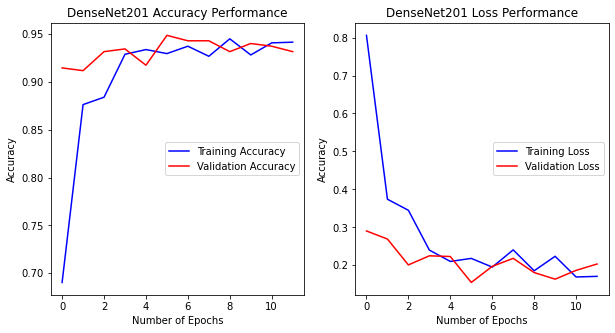

In [373]:
_, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(10,5))

base_performance_graph(ax1, EPOCHS, dense201_hist['acc'], 
                       dense201_hist['val_acc'],
                       position = 'center right', 
                       _type= 'Accuracy',
                       model_name = "DenseNet201")

base_performance_graph(ax2, EPOCHS, dense201_hist['loss'],
                       dense201_hist['val_loss'], 
                       position= 'center right',
                       _type= 'Loss',
                       model_name = "DenseNet201")

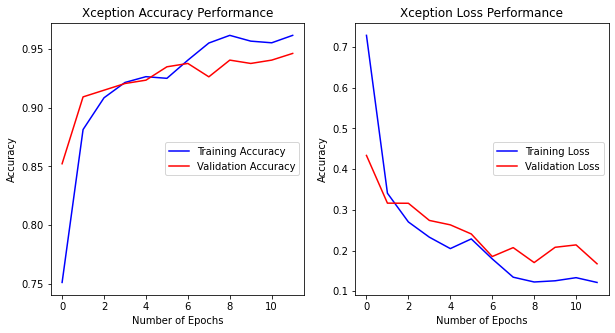

In [351]:
_, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(10,5))

base_performance_graph(ax1, EPOCHS, xception_hist['acc'], 
                       xception_hist['val_acc'],
                       position = 'center right', 
                       _type= 'Accuracy',
                       model_name = "Xception")

base_performance_graph(ax2, EPOCHS, xception_hist['loss'],
                       xception_hist['val_loss'], 
                       position= 'center right',
                       _type= 'Loss',
                       model_name = "Xception")

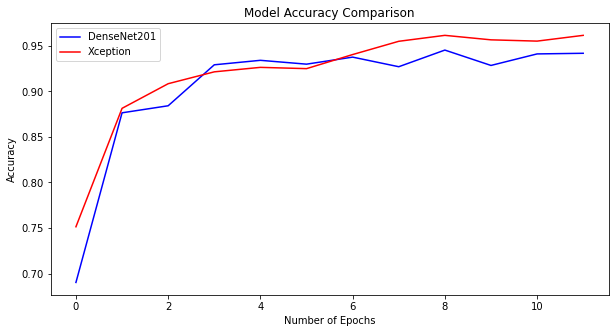

In [374]:
#Compare the two two models accuracy

_, ax = plt.subplots(figsize=(10,5))

ax.plot(EPOCHS, dense201_hist['acc'], '-b',label = 'DenseNet201')
ax.plot(EPOCHS, xception_hist['acc'], '-r', label = 'Xception')
ax.legend(loc= 'best')
ax.set_title("Model Accuracy Comparison")
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Accuracy')
plt.savefig('base_model_comparison.png')
plt.show()


Both model obtain similar accuracy of around 94%. This is a huge improvement compared to our original model

### Make predictions using Xception

In [358]:
optimal_model = tf.keras.models.load_model('optimal_weights_Xception.h5')

In [372]:
for file in random.choices(os.listdir(img_folder), k = 4):
    path = os.path.join(img_folder, file)
    img = load_img(path, target_size = (224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255
    y_pred = pre_trained_dense201.predict(x)    
    index = np.argmax(y_pred)
    label = features[index]
    acc = np.ndarray.flatten(y_pred)[index]
    print(label, acc)

rust 0.97840136
scab 0.8781137
rust 0.9955581
scab 0.9824112


### Clean Up

In [ ]:
# remove directories after finish
shutil.rmtree('train_features')
shutil.rmtree('valid_features')

### Giving Credits

Credits to 

    - Google for the tutorials so I can follow through on how to start the CNN 
        [https://developers.google.com/machine-learning/practica/image-classification]
    
    - Tensorflow for the tutorials on how to perform pre-trained models 
        [https://keras.io/guides/transfer_learning/]
    
    - And the people that create articles on medium and towards data science for making the stuff somewhat easier to understand
